# Pseudobulk differential expression to compare bri1-T vs WT

In [1]:
library(tidyverse)
library(Seurat)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)
library(muscat)
library(purrr)
library(limma)
library(scran)
library(future)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

Loading required package: grid

ComplexHeatmap version 2.11.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex hea

In [2]:
#for 200gb ram 
options(future.globals.maxSize = 200000 * 1024^2)

In [3]:
rc.integrated <- readRDS("../data/integrations/rc.integrated_15S_BRZ_bri1_Li_seu3_clean.rds")

In [4]:
rc.integrated

An object of class Seurat 
71252 features across 78435 samples within 3 assays 
Active assay: integrated (17338 features, 17338 variable features)
 2 other assays present: RNA, SCT
 4 dimensional reductions calculated: pca, umap, umap_3D, umap_2D

## Cell type and developmental stage metadata

- Developmental stage: `time_zone`
- Cell type:`cell_type`
- Combination of cell type and developmental stage: `time_zone_cell_type`
- Combination of cell type and developmental stage with cell subtypes (not used): `time_zone_cell_subtypes` 

In [5]:
feature_names <- read_tsv("./data/features.tsv.gz", col_names = c("AGI", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()


── Column specification ────────────────────────────────────────────────────────
cols(
  AGI = col_character(),
  Name = col_character(),
  Type = col_character()
)




In [6]:
table(rc.integrated$genotype)


                   bri1_T pCVP2_BRI1_Citrine_bri1_T      pGL2_BRI1_GFP_bri1_T 
                    12649                     12612                      7878 
                       WT 
                    45296 

In [7]:
rc.integrated$genotype <- factor(rc.integrated$genotype, levels=c("WT", "bri1_T", "pGL2_BRI1_GFP_bri1_T"))

In [8]:
table(rc.integrated$genotype)


                  WT               bri1_T pGL2_BRI1_GFP_bri1_T 
               45296                12649                 7878 

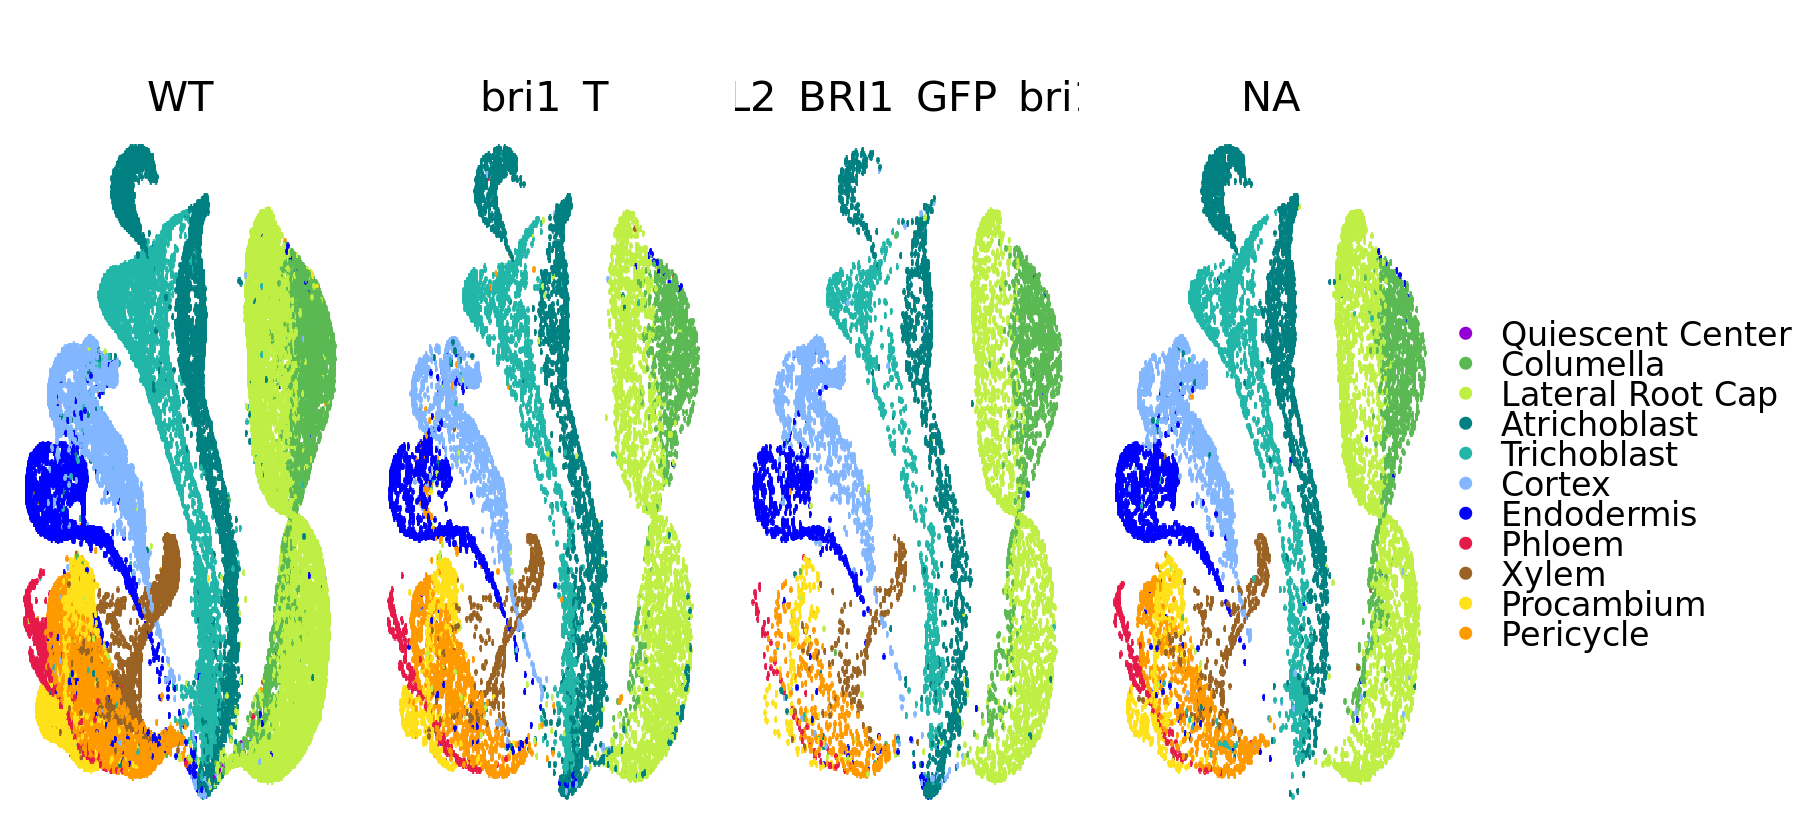

In [9]:
options(repr.plot.width=15, repr.plot.height=7)

# Plot celltype annotation Li
order <- c("Quiescent Center", "Ground Tissue","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Phloem","Protophloem", "Xylem", "Procambium","Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400D3", "#DCD0FF","#5AB953", "#BFEF45", "#008080", "#21B6A8", "#82B6FF", "#0000FF","#E6194B", "#DD77EC", "#9A6324", "#FFE119", "#FF9900", "#FFD4E3", "#9A6324", "#DDAA6F", "#EEEEEE")
rc.integrated$cell_type <- factor(rc.integrated$cell_type, levels = order[sort(match(unique(rc.integrated$cell_type),order))])
color <- palette[sort(match(unique(rc.integrated$cell_type),order))]




(cell_umap <- DimPlot(rc.integrated, reduction = "umap", group.by = "cell_type", cols = color, split.by = 'genotype', pt.size = 2, raster = T) + 
                        theme(plot.margin = margin(0.5,0.5,0.5,0.5, "cm")) + 
                         ggtitle("") +
                         theme_void(base_size = 25) &
                            theme(plot.title = element_text(hjust = 0.5)) +
theme(strip.text = NULL))

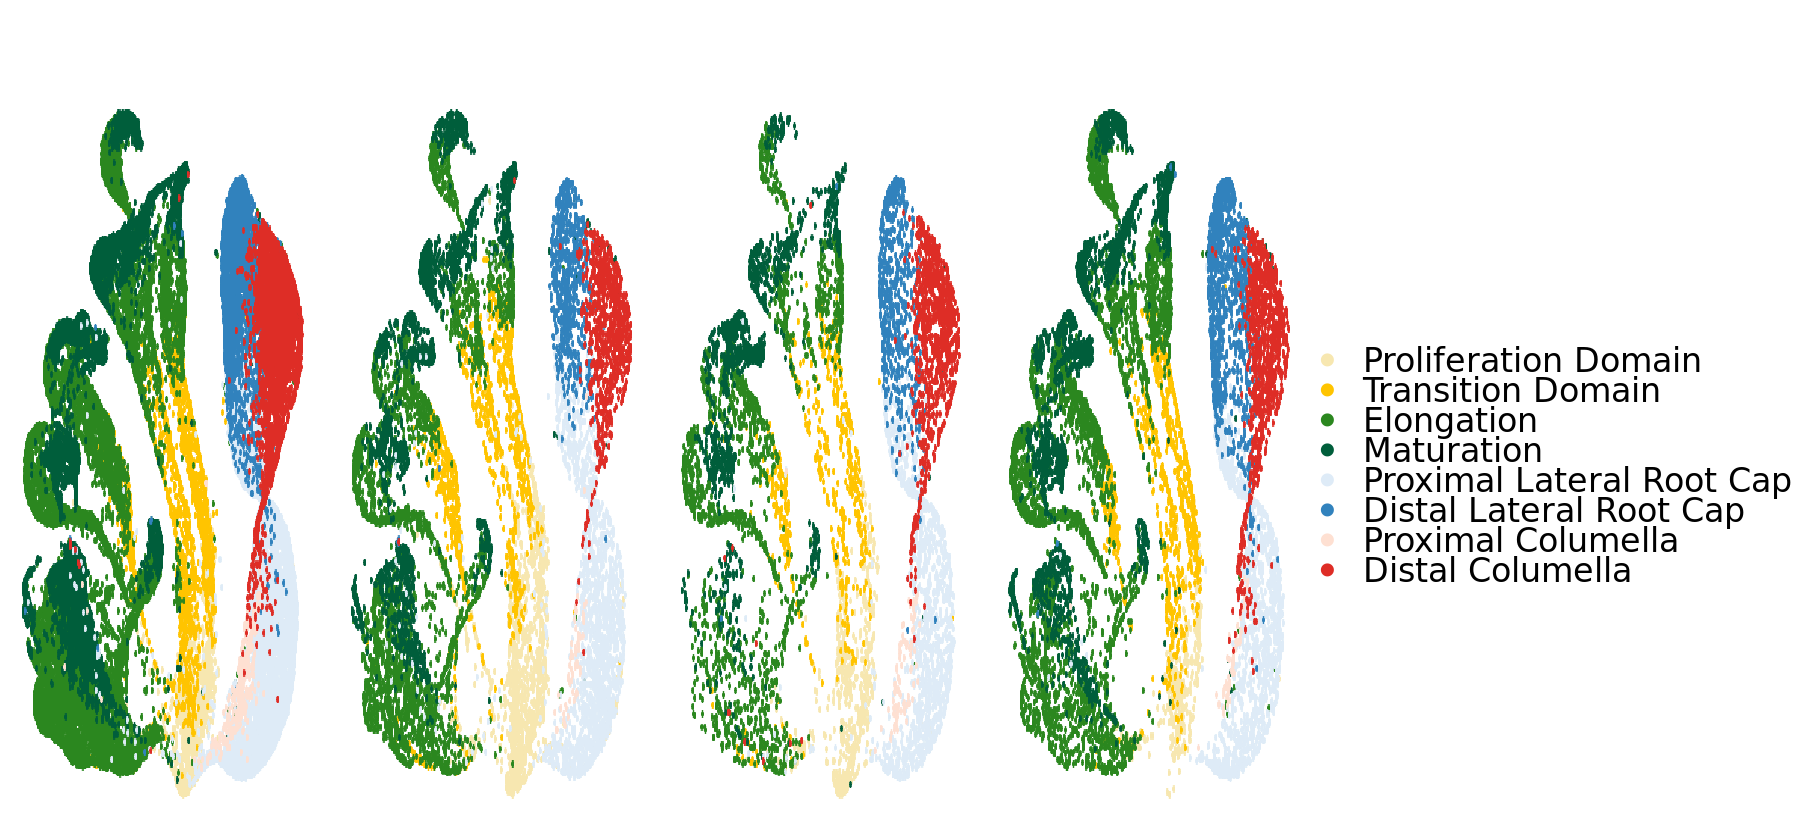

In [10]:
options(repr.plot.width=15, repr.plot.height=7)
(time_umap <-DimPlot(rc.integrated, 
        group.by = "time_zone", 
order = c("Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation", "Transition Domain", "Proliferation Domain"),
        cols = c('#F7E7B0','#FFC400','#2B871F','#005E3B', "#deebf7", "#3182bd", '#fee0d2','#de2d26'),
        split.by = 'genotype', 
        pt.size = 2, 
        raster = T) +  theme(plot.margin = margin(0.5,0.5,0.5,0.5, "cm")) + 
                         ggtitle("") +
                         theme_void(base_size = 25) &
                            theme(plot.title = element_text(hjust = 0.5))+ theme(strip.text = element_text(size=0)))

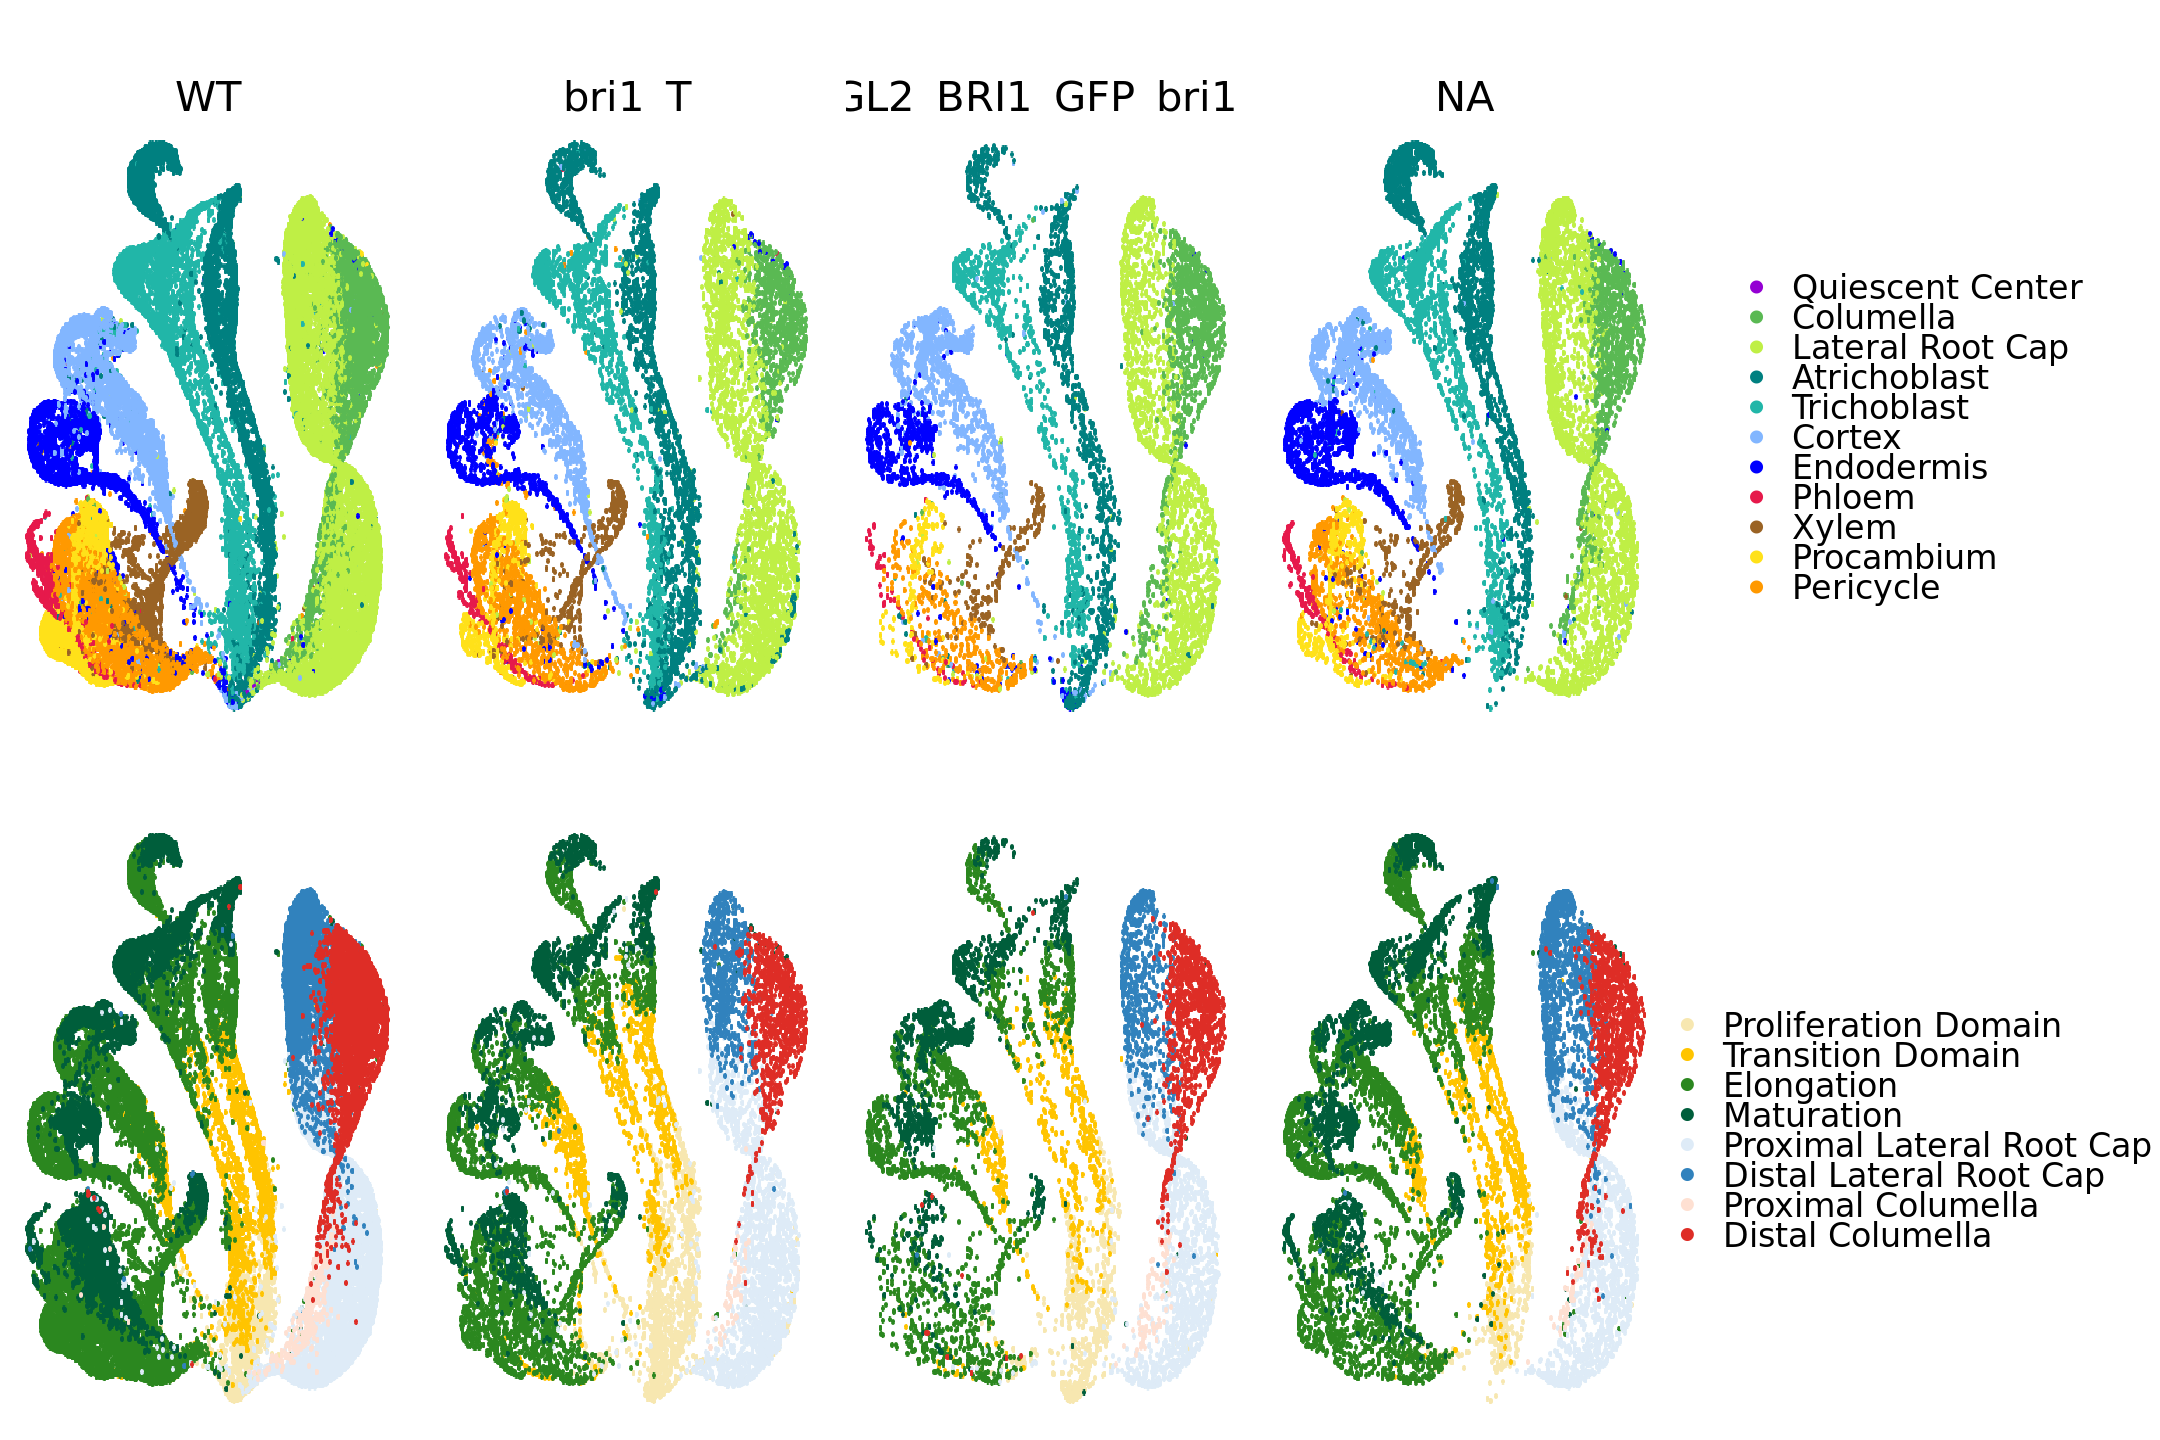

In [11]:
options(repr.plot.width=18, repr.plot.height=12)

cell_umap/time_umap

# send to BR figs repo 

ggsave("./output/bri1_T_cell_time_umaps.pdf", width=18, height=12)

# Differential State Analysis with Muscat

In [12]:
# subset samples you want to compare

integrated.de <- subset(rc.integrated, subset = sample %in% c("sc_130", "sc_134","sc_131","sc_135"))


In [13]:
integrated.de

An object of class Seurat 
71252 features across 26983 samples within 3 assays 
Active assay: integrated (17338 features, 17338 variable features)
 2 other assays present: RNA, SCT
 4 dimensional reductions calculated: pca, umap, umap_3D, umap_2D

In [14]:
# code control vs treated manually

integrated.de$treated <- integrated.de$genotype %in% c("bri1_T")


integrated.de$treatment <- as.character(integrated.de$treated)

integrated.de$treatment<- gsub("TRUE", "bri1_T", integrated.de$treatment, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)
  
integrated.de$treatment<- gsub("FALSE", "WT", integrated.de$treatment, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)

integrated.de$treatment <- factor(integrated.de$treatment, levels=c("WT", "bri1_T"))


table(integrated.de$treatment)


    WT bri1_T 
 14334  12649 

## Convert to sce

In [15]:
#  construct sce manually
my_metadata <- data.frame(sample_id = integrated.de$sample,
                              group_id = integrated.de$treatment,
                              cluster_id = integrated.de$time_zone_cell_type, 
                             date=integrated.de$rep) # include experimental rep as co-variate

sce <- SingleCellExperiment(assays = list(counts = integrated.de@assays$RNA@counts),
	                            colData = my_metadata)

In [16]:
    (sce <- prepSCE(sce, 
        kid = "cluster_id", # subpopulation assignments
        gid = "group_id",   # group IDs (ctrl/stim)
        sid = "sample_id",    # sample IDs (ctrl/stim.1234)
        drop = FALSE))        # drop all other colData columns

class: SingleCellExperiment 
dim: 29347 26983 
metadata(1): experiment_info
assays(1): counts
rownames(29347): AT1G01010 AT1G01020 ... AT5G53640 AT5G60260
rowData names(0):
colnames(26983): AAACCCACAACAGCCC_8 AAACCCACAGAGTAAT_8 ...
  TTTGTTGCAAGTGACG_13 TTTGTTGTCTACGGGC_13
colData names(4): cluster_id sample_id group_id date
reducedDimNames(0):
altExpNames(0):

## pre-filtering

In [17]:
# remove undetected genes
sce <- sce[rowSums(counts(sce) > 0) > 0, ]
dim(sce)

[1] 26552 26983

In [18]:
# remove lowly expressed genes
sce <- sce[rowSums(counts(sce) > 1) >= 1, ]
dim(sce)

[1] 22346 26983

In [19]:
# create pseudobulk profiles
pb <- aggregateData(sce,
    assay = "counts", fun = "sum",
    by = c("cluster_id", "sample_id"))
# one sheet per subpopulation
assayNames(pb)

[1] "Distal Columella"                  "Distal Lateral Root Cap"          
 [3] "Elongation_Atrichoblast"           "Elongation_Cortex"                
 [5] "Elongation_Endodermis"             "Elongation_Pericycle"             
 [7] "Elongation_Phloem"                 "Elongation_Procambium"            
 [9] "Elongation_Trichoblast"            "Elongation_Xylem"                 
[11] "Maturation_Atrichoblast"           "Maturation_Cortex"                
[13] "Maturation_Endodermis"             "Maturation_Pericycle"             
[15] "Maturation_Phloem"                 "Maturation_Procambium"            
[17] "Maturation_Trichoblast"            "Maturation_Xylem"                 
[19] "Proliferation Domain_Atrichoblast" "Proliferation Domain_Cortex"      
[21] "Proliferation Domain_Endodermis"   "Proliferation Domain_Pericycle"   
[23] "Proliferation Domain_Phloem"       "Proliferation Domain_Procambium"  
[25] "Proliferation Domain_Trichoblast"  "Proliferation Domain_Xylem"       
[27] "Proximal Columella"                "Proximal Lateral Root Cap"        
[29] "Transition Domain_Atrichoblast"    "Transition Domain_Cortex"         
[31] "Transition Domain_Endodermis"      "Transition Domain_Pericycle"      
[33] "Transition Domain_Phloem"          "Transition Domain_Procambium"     
[35] "Transition Domain_Trichoblast"     "Transition Domain_Xylem"

In [20]:
# pseudobulks for 1st subpopulation
t(head(assay(pb)))

,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060
sc_130,61,94,21,17,1787,3
sc_131,42,78,8,16,983,3
sc_134,43,62,12,14,1143,4
sc_135,9,42,3,9,521,1


In [21]:
bscs <- read.csv("./data/GEO_upload_BR_time_scRNA_samples_metadata_with_stats.csv", na.strings=c("","NA"), stringsAsFactors = F)
bscs$date <- gsub('^([0-9]{4})([0-9]{2})([0-9]+)$', '\\1-\\2-\\3', bscs$date)

bscs

sample,name,genotype,full_genotype,treatment,concentration,age,timepoint,time_trt,rep,date,seq_run,X10X_chemistry,number.of.cells,number.of.genes.detected,Median.UMI.counts.per.cell,Median.number.of.genes.detected.per.cell
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
sc_1,WT control,WT,WT Col-0,Control,DMSO,7_day,NA,Control,1,2019-12-14,Nolan_6131,v3,9759,21844,3028.0,1528.0
sc_2,WT BRZ control,WT,WT Col-0,BRZ,1uM,7_day,0.0,BRZ,1,2019-12-14,Nolan_6131,v3,7512,22403,6274.0,2497.0
sc_5,WT BRZ then 2 hour BL,WT,WT Col-0,BL,100nM,7_day,2.0,2_hour_BL,1,2019-12-14,Nolan_6131,v3,9790,22656,5415.5,2421.5
sc_43,WT BRZ control,WT,WT Col-0,BRZ,1uM,7_day,0.0,BRZ,2,2020-02-12,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4),v3,8874,22534,4936.0,2071.0
sc_44,WT BRZ then 30 mins BL,WT,WT Col-0,BL,100nM,7_day,0.5,0.5_hour_BL,2,2020-02-12,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4),v3,6843,22046,6935.0,2441.0
sc_45,WT BRZ then 1 hour BL,WT,WT Col-0,BL,100nM,7_day,1.0,1_hour_BL,2,2020-02-12,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4),v3,6336,22434,5525.5,2067.0
sc_46,WT BRZ then 2 hour BL,WT,WT Col-0,BL,100nM,7_day,2.0,2_hour_BL,2,2020-02-12,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4),v3,6847,22490,7506.0,2632.0
sc_47,WT BRZ then 4 hour BL,WT,WT Col-0,BL,100nM,7_day,4.0,4_hour_BL,2,2020-02-12,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4),v3,6907,22893,6430.0,2297.0
sc_48,WT BRZ then 8 hour BL,WT,WT Col-0,BL,100nM,7_day,8.0,8_hour_BL,2,2020-02-12,Nolan_6199 (NextSeq); Nolan_6226 (NovaSeq S4),v3,6389,22873,5230.0,2014.0


In [22]:
# experiment info for contrasts, add dates from csv

ei <- metadata(sce)$experiment_info
ei

sample_date <- select(bscs, sample_id=sample, date=rep)

ei <- left_join(ei, sample_date)

ei

sample_id,group_id,n_cells
<fct>,<fct>,<dbl>
sc_130,WT,6589
sc_131,bri1_T,7621
sc_134,WT,7745
sc_135,bri1_T,5028


Joining, by = "sample_id"



sample_id,group_id,n_cells,date
<chr>,<fct>,<dbl>,<int>
sc_130,WT,6589,1
sc_131,bri1_T,7621,1
sc_134,WT,7745,2
sc_135,bri1_T,5028,2


In [23]:
mm <- model.matrix(~ 0 + ei$group_id + ei$date)
dimnames(mm) <- list(ei$sample_id, c(levels(ei$group_id), "date"))

mm

,WT,bri1_T,date
sc_130,1,0,1
sc_131,0,1,1
sc_134,1,0,2
sc_135,0,1,2


In [24]:
contrast <- makeContrasts("bri1_T-WT", levels = mm)

contrast

,bri1_T-WT
WT,-1
bri1_T,1
date,0


In [25]:
res <- pbDS(pb, design = mm, 
            contrast = contrast, 
            method="edgeR", 
            min_cells=5, 
            filter = c("none"))

Distal Columella..Distal Lateral Root Cap..Elongation_Atrichoblast..Elongation_Cortex..Elongation_Endodermis..Elongation_Pericycle..Elongation_Phloem..Elongation_Procambium..Elongation_Trichoblast..Elongation_Xylem..Maturation_Atrichoblast..Maturation_Cortex..Maturation_Endodermis..Maturation_Pericycle..Maturation_Phloem..Maturation_Procambium..Maturation_Trichoblast..Maturation_Xylem..Proliferation Domain_Atrichoblast..Proliferation Domain_Cortex..Proliferation Domain_Endodermis..Proliferation Domain_Pericycle..Proliferation Domain_Phloem..Proliferation Domain_Procambium..Proliferation Domain_Trichoblast..Proliferation Domain_Xylem..Proximal Columella..Proximal Lateral Root Cap..Transition Domain_Atrichoblast..Transition Domain_Cortex..Transition Domain_Endodermis..Transition Domain_Pericycle..Transition Domain_Phloem..Transition Domain_Procambium..Transition Domain_Trichoblast..Transition Domain_Xylem..

### DEG results

In [26]:
# DEG results with gene freqs
(res_to_write_frq <- resDS(sce, res, bind = "row", cpm=TRUE, frq=T))

gene,cluster_id,sc_130.cpm,sc_134.cpm,sc_131.cpm,sc_135.cpm,sc_130.frq,sc_134.frq,sc_131.frq,sc_135.frq,WT.frq,bri1_T.frq,logFC,logCPM,F,p_val,p_adj.loc,p_adj.glb,contrast
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
AT1G01010,Distal Columella,9.170,9.900,8.490,3.610,0.06920,0.06880,0.06470,0.03400,0.06900,0.05560,-0.59000,3.1100,3.88e+00,4.89e-02,2.56e-01,1.00000,bri1_T-WT
AT1G01020,Distal Columella,14.100,14.300,15.800,16.900,0.09900,0.09670,0.10900,0.14700,0.09810,0.12000,0.19300,3.9600,7.14e-01,3.98e-01,8.10e-01,1.00000,bri1_T-WT
AT1G01030,Distal Columella,3.160,2.760,1.620,1.200,0.02390,0.02230,0.01260,0.01130,0.02330,0.01220,-1.03000,1.4800,3.22e+00,7.26e-02,3.33e-01,1.00000,bri1_T-WT
AT1G01040,Distal Columella,2.560,3.220,3.230,3.610,0.01910,0.02600,0.02210,0.03400,0.02180,0.02560,0.26000,1.8100,3.15e-01,5.75e-01,8.73e-01,1.00000,bri1_T-WT
AT1G01050,Distal Columella,269.000,263.000,199.000,209.000,0.78800,0.74000,0.69200,0.82300,0.76900,0.73100,-0.38500,7.8800,1.00e+01,1.56e-03,1.84e-02,1.00000,bri1_T-WT
AT1G01060,Distal Columella,0.451,0.921,0.606,0.401,0.00358,0.00743,0.00473,0.00377,0.00509,0.00445,-0.22700,0.0449,2.70e-02,8.70e-01,9.66e-01,1.00000,bri1_T-WT
AT1G01070,Distal Columella,0.150,0.230,1.820,0.401,0.00119,0.00186,0.01420,0.00377,0.00145,0.01110,2.55000,0.1210,3.17e+00,7.50e-02,3.40e-01,1.00000,bri1_T-WT
AT1G01080,Distal Columella,0.150,0.230,0.404,0.000,0.00119,0.00186,0.00315,0.00000,0.00145,0.00222,0.39200,-0.6200,2.70e-02,8.69e-01,9.66e-01,1.00000,bri1_T-WT
AT1G01090,Distal Columella,35.900,36.600,41.400,37.700,0.24000,0.24200,0.27000,0.30200,0.24100,0.27900,0.13200,5.2600,6.75e-01,4.11e-01,8.21e-01,1.00000,bri1_T-WT


In [27]:
## all genes background 

all_bg <- filter(res_to_write_frq,
                WT.frq >=0.1 | bri1_T.frq >=0.1)

In [28]:
length(unique(all_bg$gene))

[1] 17438

In [29]:
#total DE genes p_adj.loc < 0.05, abs(logFC) > 1.5
sig_DE <- filter(res_to_write_frq, p_adj.loc<=0.05 & abs(logFC) > log2(1.5))
sig_DE <- left_join(sig_DE, feature_names, by=c("gene"="AGI"))

length(unique(sig_DE$gene))

[1] 11675

In [30]:
# filter gene freqs to avoid calling lowly detected genes
sig_DE_fil <- filter(sig_DE, WT.frq >=0.1 | bri1_T.frq >=0.1)

In [31]:
length(unique(sig_DE_fil$gene))

[1] 10152

In [32]:
# load TFs
TF_list <- read_csv("./data/Kay_TF_thalemine_annotations.csv", col_names = c("gene", "TF_Name", "Description")) 


── Column specification ────────────────────────────────────────────────────────
cols(
  gene = col_character(),
  TF_Name = col_character(),
  Description = col_character()
)




In [33]:
sig_DE_fil <- left_join(sig_DE_fil, TF_list)

Joining, by = "gene"



In [34]:
# label up vs down
sig_DE_fil <- sig_DE_fil %>%
  mutate(up_dn_label = case_when(logFC >=log2(1.5) ~ "Up",  
                                       logFC <=log2(1/1.5) ~ "Down",
                                       TRUE ~ "Not DE"))

sig_DE_fil$clust_up_dn <- paste(sig_DE_fil$cluster_id, sig_DE_fil$up_dn_label, sep="_")

sig_DE_fil

gene,cluster_id,sc_130.cpm,sc_134.cpm,sc_131.cpm,sc_135.cpm,sc_130.frq,sc_134.frq,sc_131.frq,sc_135.frq,⋯,F,p_val,p_adj.loc,p_adj.glb,contrast,Name,TF_Name,Description,up_dn_label,clust_up_dn
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AT1G01100,Distal Columella,250.00,249.00,361.00,441.00,0.7410,0.7570,0.8710,0.9510,⋯,33.9,5.86e-09,2.51e-07,3.02e-03,bri1_T-WT,RPP1A,NA,NA,Up,Distal Columella_Up
AT1G01240,Distal Columella,32.50,27.20,16.20,16.50,0.2180,0.1910,0.1150,0.1360,⋯,19.9,8.13e-06,1.75e-04,1.00e+00,bri1_T-WT,AT1G01240,NA,NA,Down,Distal Columella_Down
AT1G01580,Distal Columella,36.80,33.60,15.80,20.90,0.2370,0.2230,0.1090,0.1850,⋯,27.4,1.67e-07,5.29e-06,8.56e-02,bri1_T-WT,FRO2,NA,NA,Down,Distal Columella_Down
AT1G01620,Distal Columella,479.00,289.00,246.00,159.00,0.9300,0.7880,0.7030,0.6570,⋯,59.2,1.49e-14,1.62e-12,7.76e-09,bri1_T-WT,PIP1-3,NA,NA,Down,Distal Columella_Down
AT1G01725,Distal Columella,15.20,17.30,4.45,4.01,0.1070,0.1250,0.0300,0.0377,⋯,42.9,5.80e-11,3.62e-09,3.00e-05,bri1_T-WT,AT1G01725,NA,NA,Down,Distal Columella_Down
AT1G02390,Distal Columella,21.20,35.90,15.80,19.30,0.1320,0.1690,0.0978,0.1430,⋯,10.8,1.03e-03,1.29e-02,1.00e+00,bri1_T-WT,GPAT2,NA,NA,Down,Distal Columella_Down
AT1G02400,Distal Columella,10.10,16.10,33.10,14.00,0.0680,0.1060,0.1940,0.1090,⋯,16.6,4.54e-05,8.30e-04,1.00e+00,bri1_T-WT,GA2OX6,NA,NA,Up,Distal Columella_Up
AT1G02520,Distal Columella,78.50,80.80,46.10,38.90,0.3890,0.4220,0.2590,0.2680,⋯,33.2,8.42e-09,3.47e-07,4.33e-03,bri1_T-WT,ABCB11,NA,NA,Down,Distal Columella_Down
AT1G02610,Distal Columella,21.30,23.30,15.00,11.20,0.1430,0.1540,0.1030,0.0943,⋯,11.3,7.97e-04,1.04e-02,1.00e+00,bri1_T-WT,AT1G02610,NA,NA,Down,Distal Columella_Down


In [35]:
sig_DE_fil
write.csv(sig_DE_fil, file = "./output/v4_bri1_T_v_WT_cell_time_EdgeR_q0.05_FC1.5_r_v_4_20220112.csv")

gene,cluster_id,sc_130.cpm,sc_134.cpm,sc_131.cpm,sc_135.cpm,sc_130.frq,sc_134.frq,sc_131.frq,sc_135.frq,⋯,F,p_val,p_adj.loc,p_adj.glb,contrast,Name,TF_Name,Description,up_dn_label,clust_up_dn
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AT1G01100,Distal Columella,250.00,249.00,361.00,441.00,0.7410,0.7570,0.8710,0.9510,⋯,33.9,5.86e-09,2.51e-07,3.02e-03,bri1_T-WT,RPP1A,NA,NA,Up,Distal Columella_Up
AT1G01240,Distal Columella,32.50,27.20,16.20,16.50,0.2180,0.1910,0.1150,0.1360,⋯,19.9,8.13e-06,1.75e-04,1.00e+00,bri1_T-WT,AT1G01240,NA,NA,Down,Distal Columella_Down
AT1G01580,Distal Columella,36.80,33.60,15.80,20.90,0.2370,0.2230,0.1090,0.1850,⋯,27.4,1.67e-07,5.29e-06,8.56e-02,bri1_T-WT,FRO2,NA,NA,Down,Distal Columella_Down
AT1G01620,Distal Columella,479.00,289.00,246.00,159.00,0.9300,0.7880,0.7030,0.6570,⋯,59.2,1.49e-14,1.62e-12,7.76e-09,bri1_T-WT,PIP1-3,NA,NA,Down,Distal Columella_Down
AT1G01725,Distal Columella,15.20,17.30,4.45,4.01,0.1070,0.1250,0.0300,0.0377,⋯,42.9,5.80e-11,3.62e-09,3.00e-05,bri1_T-WT,AT1G01725,NA,NA,Down,Distal Columella_Down
AT1G02390,Distal Columella,21.20,35.90,15.80,19.30,0.1320,0.1690,0.0978,0.1430,⋯,10.8,1.03e-03,1.29e-02,1.00e+00,bri1_T-WT,GPAT2,NA,NA,Down,Distal Columella_Down
AT1G02400,Distal Columella,10.10,16.10,33.10,14.00,0.0680,0.1060,0.1940,0.1090,⋯,16.6,4.54e-05,8.30e-04,1.00e+00,bri1_T-WT,GA2OX6,NA,NA,Up,Distal Columella_Up
AT1G02520,Distal Columella,78.50,80.80,46.10,38.90,0.3890,0.4220,0.2590,0.2680,⋯,33.2,8.42e-09,3.47e-07,4.33e-03,bri1_T-WT,ABCB11,NA,NA,Down,Distal Columella_Down
AT1G02610,Distal Columella,21.30,23.30,15.00,11.20,0.1430,0.1540,0.1030,0.0943,⋯,11.3,7.97e-04,1.04e-02,1.00e+00,bri1_T-WT,AT1G02610,NA,NA,Down,Distal Columella_Down


In [36]:
# add DE and up/dn to total list
sig_to_join <- sig_DE_fil %>%
mutate(clust_gene=paste(cluster_id, gene, sep="_")) %>%
select(clust_gene, up_dn_label, clust_up_dn)

In [37]:
# join all genes list to DE labels
all_bg <- mutate(all_bg, clust_gene=paste(cluster_id, gene, sep="_"))

all_bg <- left_join(all_bg, feature_names, by=c("gene"="AGI"))

all_bg$DE <- all_bg$clust_gene %in% sig_to_join$clust_gene


all_bg <- all_bg %>%
left_join(sig_to_join, by="clust_gene") %>%
arrange(all_bg, p_adj.loc)

write.csv(all_bg, file = "./output/v4_all_bri1_T_v_WT_cell_time_EdgeR_q0.05_FC1.5_r_v_4_20220112.csv")